Imports

In [1]:
from pvlib import solarposition
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt

Solar position

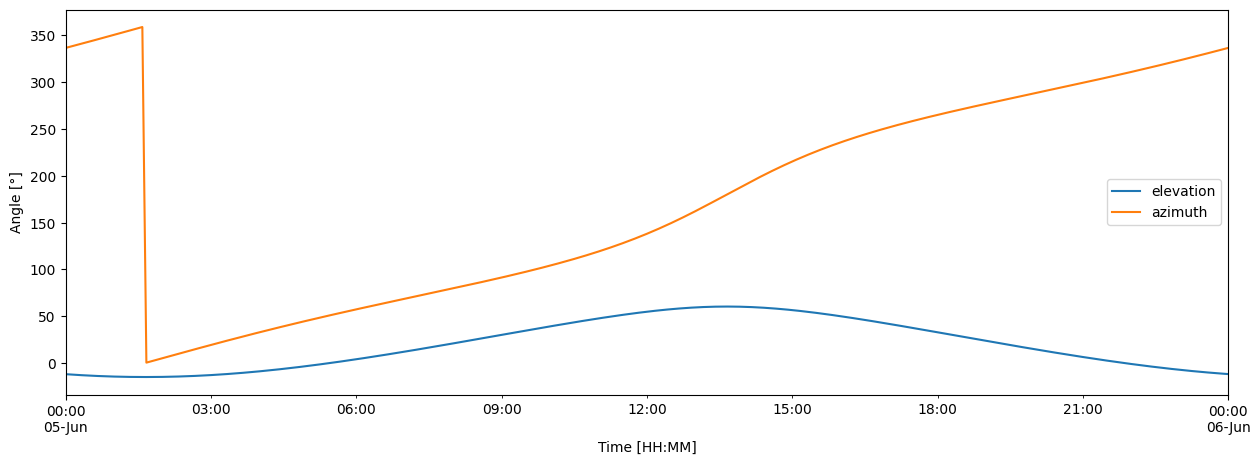

In [2]:
tz = 'CET'
lat, lon = 52.35850757579532, 4.881107791550871

# summer
start_date = '2022-06-05'
end_date = '2022-06-06'

# winter
# start_date = '2022-12-05'
# end_date = '2022-12-06'

times = pd.date_range(start=start_date, end=end_date, freq='5min', tz=tz)
solpos = solarposition.get_solarposition(times, lat, lon)

# plot of elevation and azimuth
plt.figure(figsize=(15, 5))
solpos['elevation'].plot(label='elevation')
solpos['azimuth'].plot(label='azimuth')
plt.ylabel('Angle [°]')
plt.xlabel('Time [HH:MM]')
plt.legend()
plt.show()

Calculate heights of blind

In [3]:
from numpy import cos, tan, radians

def calculate_blind_height(sol_elev: float, sol_azi: float, win_azi, azi_min, azi_max, d: float, h_def: float) -> np.ndarray:
    """
    Calculate the height of the blind based on the sun position and the panel tilt and azimuth.

    :param sol_elev: elevation of the sun in degrees
    :param sol_azi: azimuth of the sun in degrees
    :param win_azi: azimuth of the panel in degrees from north
    :param win_tilt: tilt of the panel in degrees
    :param d: distance between the working area and window facade in meters
    """

    # surface solar azimuth
    gamma = radians(sol_azi - win_azi)

    # solar elevation
    alpha = radians(sol_elev)

    # all angles above the horizon and within the half circle of the window facade
    valid = np.logical_and((np.abs(gamma) < np.pi / 2), (alpha > 0))

    # filter out sun azimuth outside azi_min and azi_max    
    valid = np.logical_and(valid, ((sol_azi > azi_min) & (sol_azi < azi_max)))

    # calculate blind height
    return np.where(valid, (d / cos(gamma)) * tan(alpha), h_def)

Plot heights of blind

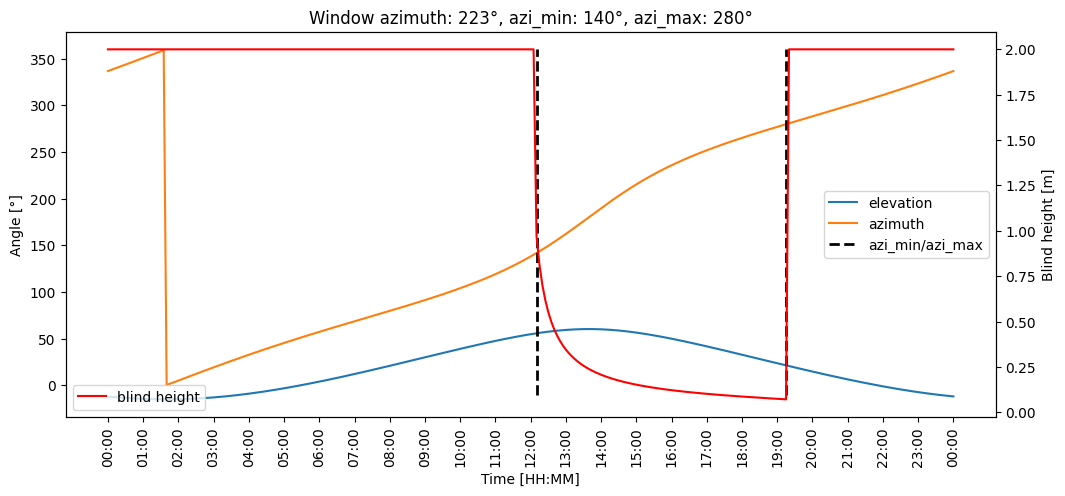

In [9]:
# variables
win_azi = 223
win_tilt = 0
h_max = 2.0
dis_workplane = 0.1
time = solpos.index

# azi min and max
azi_min = 140
azi_max = 280

# default height
h_def = 2.0

# plot of blind height
ax, fig = plt.subplots(figsize=(12, 5))
plt.title(f"Window azimuth: {win_azi}°, azi_min: {azi_min}°, azi_max: {azi_max}°")
plt.plot(solpos['elevation'].values, label='elevation')
plt.plot(solpos['azimuth'].values, label='azimuth')

# two vlines, one at azi_min and one at azi_max
pos = np.where(np.logical_and(solpos['azimuth'].values > azi_min, solpos['azimuth'].values < azi_max))[0]
plt.vlines(pos[0], -10, 360, color='black', linestyle='--', linewidth=2, label='azi_min/azi_max')
plt.vlines(pos[-1], -10, 360, color='black', linestyle='--', linewidth=2 )
plt.xticks(np.arange(0, len(time), 12), time[::12].strftime('%H:%M'), rotation=90)
plt.ylabel('Angle [°]')
plt.xlabel('Time [HH:MM]')
plt.legend()

# plot of blind height
ax2 = fig.twinx()
blind_height = np.clip(calculate_blind_height(solpos['elevation'], solpos['azimuth'], win_azi, azi_min=azi_min, azi_max=azi_max, d=dis_workplane, h_def=h_def), 0, h_max)
ax2.plot(blind_height, label='blind height', color='red')

plt.ylabel('Blind height [m]')
plt.legend()
plt.show()